In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
config = configClasses.GEM()
config.L1_REG = 0
config.EPOCHS = 20
config.SAVE_PATH = './models/permuted_minst/multikaf_kernel_combination'
config.IS_CONVOLUTIONAL = False
config.MODEL_NAME = ''
print(config)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 0.5
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.GEM'>
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/multikaf_kernel_combination
USE_EWC: True
USE_TENSORBOARD: True



In [6]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [7]:
multikaf = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination='softmax')

In [8]:
experiments_multikaf = ['attention', 'softmax', 'sigmoid', 'sum']
results_multikaf = []

In [9]:
for name in experiments_multikaf:
    print(name)
    
    n = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination=name)
    
    d = n.state_dict()
    d.update({k: v for k, v in multikaf.state_dict().items()})
    
    n.load_state_dict(d)

    config.MODEL_NAME = name

    trainer = Trainer(n, deepcopy(dataset), config)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
    
    results_multikaf.append((name, r))
    
    del trainer
    del n

attention


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:53<00:00, 16.42it/s, loss=1.12, batch#=875]
Testing task 0: 219it [00:08, 25.94it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:53<00:00, 16.34it/s, loss=0.435, batch#=875]
Testing task 0: 219it [00:08, 26.07it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:54<00:00, 16.09it/s, loss=0.343, batch#=875]
Testing task 0: 219it [00:08, 24.02it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:54<00:00, 16.19it/s, loss=0.294, batch#=875]
Testing task 0: 219it [00:08, 26.89it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:52<00:00, 16.54it/s, loss=0.258, batch#=875]
Testing task 0: 219it [00:08, 27.12it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:51<00:00, 16.87it/s, loss=0.23, batch#=875] 
Testing task 0: 219it [00:08, 26.94it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████████

Testing task 1: 219it [00:08, 26.47it/s, batch#=219]
Training task (ewc) 2, epoch 3: 100%|██████████| 875/875 [01:31<00:00,  9.58it/s, loss=0.266, batch#=875]
Testing task 2: 219it [00:08, 26.36it/s, batch#=219]
Testing task 0: 219it [00:08, 26.33it/s, batch#=219]
Testing task 1: 219it [00:08, 26.37it/s, batch#=219]
Training task (ewc) 2, epoch 4: 100%|██████████| 875/875 [01:32<00:00,  9.31it/s, loss=0.228, batch#=875]
Testing task 2: 219it [00:08, 26.19it/s, batch#=219]
Testing task 0: 219it [00:08, 26.21it/s, batch#=219]
Testing task 1: 219it [00:08, 26.42it/s, batch#=219]
Training task (ewc) 2, epoch 5: 100%|██████████| 875/875 [01:31<00:00,  9.36it/s, loss=0.207, batch#=875]
Testing task 2: 219it [00:08, 26.37it/s, batch#=219]
Testing task 0: 219it [00:08, 26.18it/s, batch#=219]
Testing task 1: 219it [00:08, 26.53it/s, batch#=219]
Training task (ewc) 2, epoch 6: 100%|██████████| 875/875 [01:31<00:00,  9.42it/s, loss=0.188, batch#=875]
Testing task 2: 219it [00:08, 26.04it/s, batch

Testing task 3: 219it [00:08, 26.85it/s, batch#=219]
Testing task 0: 219it [00:08, 26.83it/s, batch#=219]
Testing task 1: 219it [00:08, 26.83it/s, batch#=219]
Testing task 2: 219it [00:08, 26.92it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [01:41<00:00,  8.88it/s, loss=0.109, batch#=875]
Testing task 3: 219it [00:08, 25.99it/s, batch#=219]
Testing task 0: 219it [00:08, 26.05it/s, batch#=219]
Testing task 1: 219it [00:08, 25.84it/s, batch#=219]
Testing task 2: 219it [00:08, 25.93it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [01:41<00:00,  8.48it/s, loss=0.105, batch#=875] 
Testing task 3: 219it [00:08, 26.08it/s, batch#=219]
Testing task 0: 219it [00:08, 26.07it/s, batch#=219]
Testing task 1: 219it [00:08, 26.12it/s, batch#=219]
Testing task 2: 219it [00:08, 25.93it/s, batch#=219]
Training task (ewc) 3, epoch 14: 100%|██████████| 875/875 [01:49<00:00,  8.20it/s, loss=0.0996, batch#=875]
Testing task 3: 219it [00:08, 26.20it/s, 

softmax
sigmoid
sum


In [10]:
print('RESULTS')
for name, r in results_multikaf:
    print(name, r['metrics'])
    print()

RESULTS
attention {'fwt': 0.9666666666666667, 'bwt': 0.002571428571428558, 'remembering': 1, 'pbwt': 0.002571428571428558, 'accuracy': 0.4524214285714286}

softmax {'fwt': 0.9680238095238095, 'bwt': 0.0046071428571429025, 'remembering': 1, 'pbwt': 0.0046071428571429025, 'accuracy': 0.44774285714285716}

sigmoid {'fwt': 0.9717857142857143, 'bwt': -0.00045238095238094483, 'remembering': 0.999547619047619, 'pbwt': 0, 'accuracy': 0.4494071428571429}

sum {'fwt': 0.9689285714285716, 'bwt': 0.0006428571428571858, 'remembering': 1, 'pbwt': 0.0006428571428571858, 'accuracy': 0.4548285714285714}



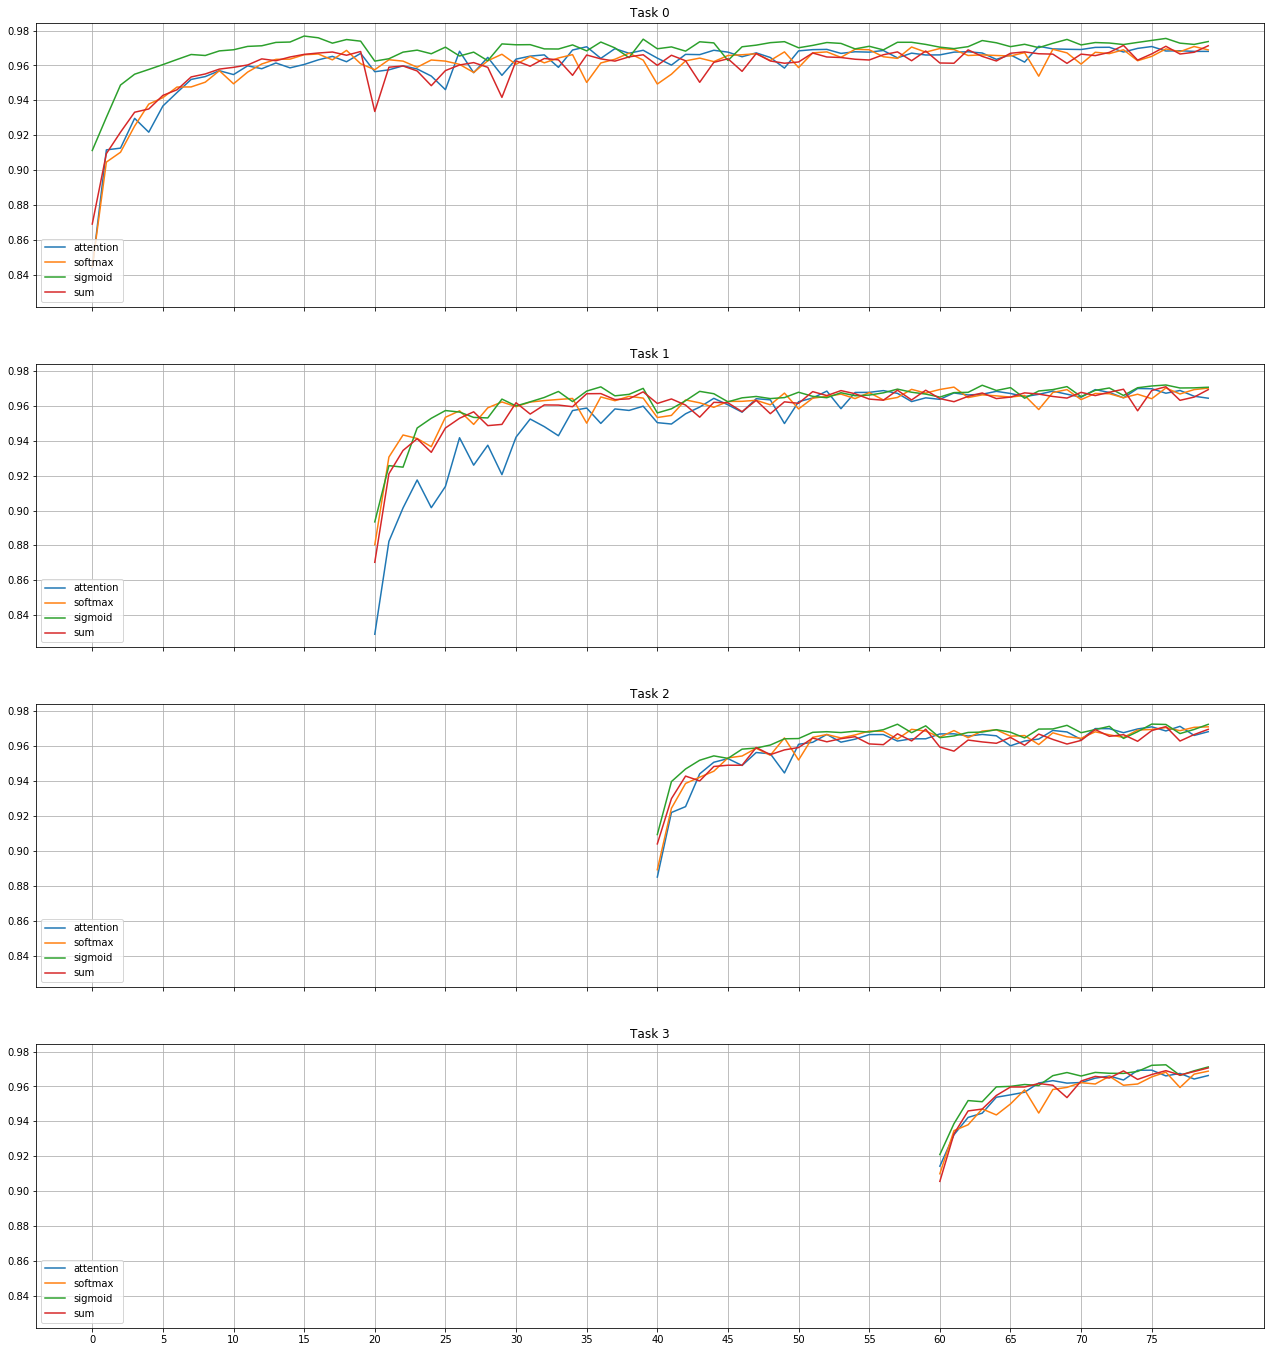

In [11]:
n_task = len(results_multikaf[0][1]['tasks'])

tot_epochs = 0

for _, r in results_multikaf:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=n_task, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results_multikaf:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]
        #no_ewt = metrics_no_ewt['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        #ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 

        ax[i].plot(x, com['accuracy'], label=name)
        #ax.plot(x, no_ewt['accuracy'], label='online ewt')

        ax[i].set_xticks(range(0, tot_epochs, 5),minor=False)

        ax[i].set_title("Task {}".format(task))
        ax[i].legend(loc="lower left")
        ax[i].grid(True, axis='both')
        